In [1]:
import ast
import torch
torch.cuda.current_device()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from prediction.evaluation import compute_rNMSEs_per_step, compute_iteration_rNMSE
from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, \
    convert_data_to_graph_time_pr_graph, get_name_string, get_dataset

from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered

from utils.graph_utils import permutation_by_degree

device = get_device(use_gpu=True)

Device selected: cuda:0


In [74]:
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_MOLENE\\grid_search_2l_taps=[2, 2]\\full\\"
# model_name = "20200127230508_1step-GTCNN_lr=0.005_b=150_L=2_F=[8, 2]_T=[2, 2]_P=[4, 1]_R=[1, 1]_N=[32, 32]"

runs_dir = "C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\MOLENE\\runs_MOLENE_w=4_old\\"
model_name = "20200301085106_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True"
model_path = runs_dir + model_name

In [75]:
elements = model_name.split("_")[5:]
elements

['F=[8, 12]',
 'T=[2, 2]',
 'P=[2, 2]',
 'R=[1, 1]',
 'N=[25, 16]',
 'wd=0',
 'cyclic=True',
 'r=0',
 'tdirect=True']

In [76]:
cyclic = 'cyclic=True' in model_name
time_directed = 'tdirect=False' not in model_name

print(f"Cyclic: {cyclic}")
print(f"Time directed: {time_directed}")

Cyclic: True
Time directed: True


In [77]:
BEST = True
NORMALIZE_ADJACENCY_MATRIX = False

# --------------------------------------------------------------------------------------

# Loading the data

In [78]:
allowed_datasets = ['MOLENE', 'NOAA']
ds_type = allowed_datasets[0]
ds_folder=r"../../prediction/"
splits = [0.35, 0.15, 0.5]
obs=4


dataset, observation_window, N_spatial_nodes, steps_ahead, weighted_adj, in_sample_means = get_dataset(
    ds_type,
    ds_folder,
    NORMALIZE_ADJACENCY_MATRIX,
    splits=splits,
    obs_window=obs
)
print(f"{N_spatial_nodes} nodes - {observation_window} observed timesteps - steps ahead: {steps_ahead}")



MOLENE is selected



Dataset path: ../../prediction//MOLENE/dataset/processed/dataset_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
Sample means: ../../prediction//MOLENE/dataset/processed/in_sample_means_0.5.pickle
32 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]


In [79]:
# Get data (We do not need test data/labels here)
_, _, tst_data, _, _, tst_labels = transform_data_to_all_steps_prediction(dataset, node_first=True, device=device)

print(tst_data.shape, tst_labels.shape)

torch.Size([364, 1, 32, 4]) torch.Size([364, 5, 32])


In [80]:
tst_data = tst_data.float()
tst_labels = tst_labels.float()

# Create the model
This must match the model we are going to load from the checkpoint

In [81]:
import ast


start = 5

features = ast.literal_eval(model_name.split("_")[start].split("=")[1])
taps = ast.literal_eval(model_name.split("_")[start+1].split("=")[1])
pool_ratios = ast.literal_eval(model_name.split("_")[start+2].split("=")[1])
reach = ast.literal_eval(model_name.split("_")[start+3].split("=")[1])
nodes = ast.literal_eval(model_name.split("_")[start+4].split("=")[1])

for elem in [features, taps, pool_ratios, reach, nodes]:
    print(elem)

[8, 12]
[2, 2]
[2, 2]
[1, 1]
[25, 16]


In [82]:
feat_per_layer = [1] + features
taps_per_layer = taps
pool_reach_per_layer = reach
active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
time_pooling_ratio_per_layer = pool_ratios



one_step_gtcnn = ParametricNetWithPoolingOrdered(
    window=observation_window,
    cyclic_time_graph=cyclic,
    time_directed=time_directed,
    S_spatial=weighted_adj,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

one_step_gtcnn.to(device)
print(one_step_gtcnn)

Initialization (random) with gain 0.2
Initialization (random) with gain 0.2
ParametricNetWithPoolingOrdered(
  (GFL): Sequential(
    (0): ParametricGraphFilter(in_features=1, out_features=8, filter_taps=2, edge_features=1, timesteps= 4, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0	# params= 28)
    (1): ReLU()
    (2): SpaceTimeMaxPooling(nodes_in=128, nodes_out=50, hops=1, steps_in=4, steps_out=2, tot_st_nodes=128, time_pooling_step= 2, slices_to_pool=[0, 2])
    (3): ParametricGraphFilter(in_features=8, out_features=12, filter_taps=2, edge_features=1, timesteps= 2, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0	# params= 208)
    (4): ReLU()
    (5): SpaceTimeMaxPooling(nodes_in=50, nodes_out=16, hops=1, steps_in=2, steps_out=1, tot_st_nodes=64, time_pooling_step= 2, slices_to_pool=[0])
  )
  (fc): Linear(in_features=192, out_features=32, bias=True)
)


In [83]:
model_parameters = filter(lambda p: p.requires_grad, one_step_gtcnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Number of parameters: 6412


# Load the model

best model was at epoch: 345


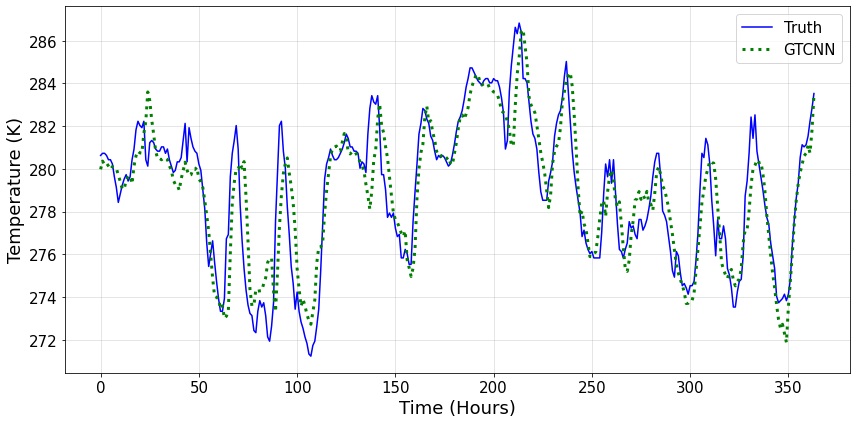

345
{1: tensor(0.3190, device='cuda:0'), 2: tensor(0.3813, device='cuda:0'), 3: tensor(0.4391, device='cuda:0'), 4: tensor(0.5142, device='cuda:0'), 5: tensor(0.5718, device='cuda:0')}


In [136]:
naming = "best" if BEST else "last"
checkpoint = torch.load(f"{model_path}/{naming}_one_step_gtcnn.pth") 

one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

one_step_gtcnn.eval()
print(f"{naming} model was at epoch: {epoch}")


rNMSE_dict, predictions_dict = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)


node_to_visualize = 3 # 3, 5, 7, 9, 17, 25
step_ahead = 3

pred = predictions_dict[step_ahead][:, node_to_visualize].cpu()
truth = tst_labels[:, step_ahead-1, node_to_visualize].cpu()
assert pred.shape == truth.shape
insample_mean = 281.33
pred = pred + insample_mean
truth = truth + insample_mean
indices = list(range(truth.shape[0]))

truth_style = '-'
pred_style = ':'
# plot of all_data
plt.figure(figsize=(12, 6))
plt.plot(indices, truth[indices], 'b', linestyle=truth_style, label='Truth')  # plotting t, a separately
plt.plot(indices, pred[indices], 'g', linestyle=pred_style, label='GTCNN', linewidth=3)  # plotting t, b separately

plt.xlabel("Time (Hours)", fontsize=18)
plt.ylabel("Temperature (K)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.4)
plt.legend(fontsize=15)

plt.grid(alpha=0.4)
plt.tight_layout()

plt.savefig(r"C:\Users\gabri\Desktop" + f"\molene_step{step_ahead}_node{node_to_visualize}.pdf")
plt.show()




print(epoch)
print(rNMSE_dict)

# Computing metrics

In [24]:
trn_data, val_data, tst_data, trn_labels, val_labels, tst_labels = transform_data_to_all_steps_prediction(dataset, node_first=True, device=device)

trn_data=trn_data.float()
val_data=val_data.float()
tst_data=tst_data.float()

trn_labels = trn_labels.float()
val_labels = val_labels.float()
tst_labels = tst_labels.float()

In [27]:
def itemize_dictionary(dictionary, round_digits):
    for k,i in dictionary.items():
        dictionary[k] = round(i.item(), round_digits)
    return dictionary

In [28]:
rNMSEs_trn_dict, trn_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, trn_data, trn_labels, device, verbose=False)
rNMSEs_trn_dict = itemize_dictionary(rNMSEs_trn_dict, 3)
avg_trn_rNMSE = round(np.average(list(rNMSEs_trn_dict.values())), 5)
print(f"Average rNMSE on trn set: {avg_trn_rNMSE}")
print(f"rNMSE per step on trn set: {rNMSEs_trn_dict}")

rNMSEs_val_dict, val_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, val_data, val_labels, device, verbose=False)
rNMSEs_val_dict = itemize_dictionary(rNMSEs_val_dict, 3)
avg_val_rNMSE = round(np.average(list(rNMSEs_val_dict.values())), 5)
print(f"\nAverage rNMSE on val set: {avg_val_rNMSE}")
print(f"rNMSE per step on val set: {rNMSEs_val_dict}")

rNMSEs_tst_dict, tst_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)
rNMSEs_tst_dict = itemize_dictionary(rNMSEs_tst_dict, 3)
avg_tst_rNMSE = round(np.average(list(rNMSEs_tst_dict.values())), 5)
print(f"\nAverage rNMSE on test set: {avg_tst_rNMSE}")
print(f"rNMSE per step on test set: {rNMSEs_tst_dict}")

print("\n", model_path)

print("\n", epoch)

Average rNMSE on trn set: 0.5144
rNMSE per step on trn set: {1: 0.318, 2: 0.412, 3: 0.515, 4: 0.622, 5: 0.705}

Average rNMSE on val set: 0.4726
rNMSE per step on val set: {1: 0.335, 2: 0.401, 3: 0.472, 4: 0.546, 5: 0.609}

Average rNMSE on test set: 0.445
rNMSE per step on test set: {1: 0.319, 2: 0.381, 3: 0.439, 4: 0.514, 5: 0.572}

 C:\Users\gabri\Desktop\new_thesis_project\prediction\MOLENE\runs_MOLENE_w=4\20200301085106_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True

 345


In [29]:
BEST

True

In [9]:
g_varma_rNMSEs = [0.1921449, 0.29251406, 0.3961603, 0.49754531, 0.58871755]
gp_var_rNMSEs = [0.19419846, 0.29567637, 0.40296721, 0.51051343, 0.61125471]
persistence = [0.2344, 0.3757, 0.5024, 0.6143, 0.7105]
lstm_rNMSEs = [0.3322, 0.4271, 0.5399, 0.6453, 0.734]
GGRNN_rNMSEs = [0.2941, 0.4098, 0.5303, 0.642, 0.7398]

avg_GTCNN = [0.3287,
            0.387,
            0.473,
            0.5652,
            0.6445]
# 20200610221840_lr=0.001_b=64_w=4_L=2_F=[10, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True

MOLENE


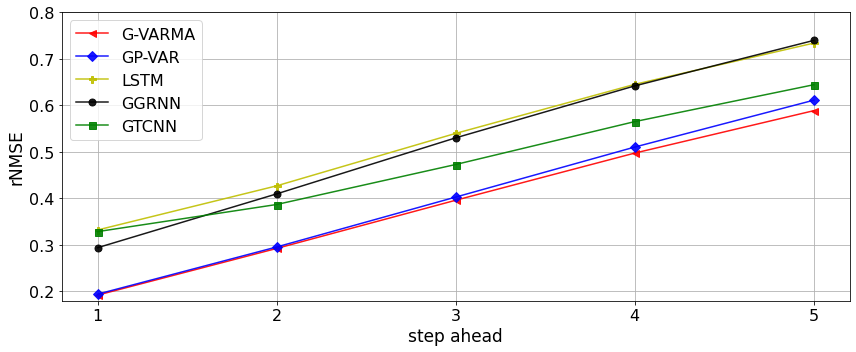

In [19]:
from matplotlib.ticker import MaxNLocator


ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.plot(steps_ahead, list(rNMSEs_tst_dict.values()), 'g', marker='s', label='GTCNN')
alpha = 0.9
mksize= 7
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', marker='<',label='G-VARMA', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', marker='D', label='GP-VAR', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, lstm_rNMSEs, 'y', marker='P', label='LSTM', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, GGRNN_rNMSEs, 'black', marker='o', label='GGRNN', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, avg_GTCNN, 'green', marker='s', label='GTCNN', markersize=mksize, alpha=alpha)

plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE", fontsize=17)
plt.legend(fontsize=16, loc="upper left")
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
plt.ylim(0.18, 0.8)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

print(model_path.split("_")[3])

plt.savefig("C:\\Users\\gabri\\Desktop\\molene_results_new.pdf")
plt.tight_layout()
plt.show()

In [32]:
print(f"Average rNMSE on trn set: {avg_trn_rNMSE}")
print(f"rNMSE per step on trn set: {rNMSEs_trn_dict}")
print(f"\nAverage rNMSE on val set: {avg_val_rNMSE}")
print(f"rNMSE per step on val set: {rNMSEs_val_dict}")
print(f"\nAverage rNMSE on test set: {avg_tst_rNMSE}")
print(f"rNMSE per step on test set: {rNMSEs_tst_dict}")

Average rNMSE on trn set: 0.5144
rNMSE per step on trn set: {1: 0.318, 2: 0.412, 3: 0.515, 4: 0.622, 5: 0.705}

Average rNMSE on val set: 0.4726
rNMSE per step on val set: {1: 0.335, 2: 0.401, 3: 0.472, 4: 0.546, 5: 0.609}

Average rNMSE on test set: 0.445
rNMSE per step on test set: {1: 0.319, 2: 0.381, 3: 0.439, 4: 0.514, 5: 0.572}


In [33]:
epoch

345

# Increase

In [82]:
# deltas

def get_deltas(values_list):
    return [values_list[i+1] - values_list[i] for i, _ in enumerate(values_list[1:])]

g_varma_deltas = get_deltas(g_varma_rNMSEs)
gp_var_deltas = get_deltas(gp_var_rNMSEs)
lstm_deltas = get_deltas(lstm_rNMSEs)
GGRNN_deltas = get_deltas(GGRNN_rNMSEs)
avg_GTCNN_deltas = get_deltas(avg_GTCNN)

In [86]:
# relative
def get_relative_deltas(values_list):
    one_step_error = values_list[0]
    new_values = []
    for error in values_list[1:]:
        new_values.append( (error-one_step_error) / one_step_error * 100)
    return new_values

g_varma_deltas = get_relative_deltas(g_varma_rNMSEs)
gp_var_deltas = get_relative_deltas(gp_var_rNMSEs)
lstm_deltas = get_relative_deltas(lstm_rNMSEs)
GGRNN_deltas = get_relative_deltas(GGRNN_rNMSEs)
avg_GTCNN_deltas = get_relative_deltas(avg_GTCNN)

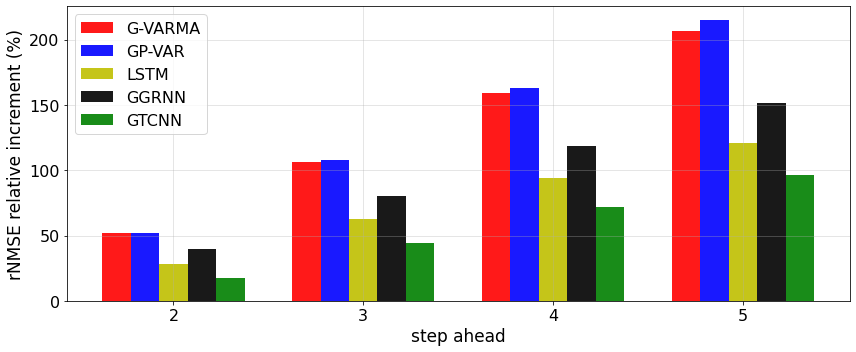

In [93]:



ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ind = np.arange(len(g_varma_deltas))  # the x locations for the groups
width = 0.15  # the width of the bars

alpha = 0.9
rects1 = ax.bar(ind - 2*width, g_varma_deltas, width, color='r', label='G-VARMA', alpha=alpha)
rects2 = ax.bar(ind - width, gp_var_deltas, width, color='b', label='GP-VAR', alpha=alpha)
rects3 = ax.bar(ind, lstm_deltas, width, color='y', label='LSTM', alpha=alpha)
rects4 = ax.bar(ind + width, GGRNN_deltas, width, color='black', label='GGRNN', alpha=alpha)
rects5 = ax.bar(ind + 2*width, avg_GTCNN_deltas, width, color='g', label='GTCNN', alpha=alpha)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rNMSE increase')
ax.set_xticks(ind)
ax.set_xticklabels(('2', '3', '4', '5'), fontsize=17)
ax.legend()
plt.grid(alpha=0.4)

plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE relative increment (%)", fontsize=17)
plt.legend(fontsize=16, loc="upper left")
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.ylim()


plt.tight_layout()

plt.savefig("C:\\Users\\gabri\\Desktop\\molene_increases.pdf")


plt.show()